In [11]:
! pip install catboost


In [12]:
! pip install category_encoders

In [13]:
! pip install xgboost

In [14]:
import optuna

In [15]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns


from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

from catboost import CatBoostRegressor
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


import tqdm
import joblib

import shap

pd.set_option('display.max_columns', 70)
plt.rcParams['axes.spines.top']=False
plt.rcParams['axes.spines.right']=False
style.use('ggplot')
sns.set_palette('Set2')

import warnings
warnings.filterwarnings('ignore')

In [16]:
train = pd.read_csv('../train_dataset.csv')
test = pd.read_csv('../x_test.csv')

In [17]:
df_train = train.copy()
df_test = test.copy()

In [18]:
print(df_train.shape)
print(df_test.shape)

(75757, 64)
(9705, 63)


In [19]:
train

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.500000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6,State_11,Commercial,Office_Uncategorized,20410.0,1995.0,8.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,NaN,NaN,NaN,NaN,132.918411,75752
75753,6,State_11,Residential,5plus_Unit_Building,40489.0,1910.0,98.0,36.6,28,43.451613,56,34,47.672414,64,35,49.354839,71,40,56.266667,89,45,59.193548,88,47,63.566667,91,54,66.951613,87,52,68.612903,91,44,61.383333,79,39,55.403226,68,40,51.283333,71,24,38.532258,51,260,3772,45.03,1.4,1,55.147541,6,0,0,0,25,3,0,0,NaN,NaN,NaN,NaN,39.483672,75753
75754,6,State_11,Commercial,Commercial_Other,28072.0,1917.0,NaN,36.6,26,36.612903,48,30,41.637931,58,29,41.338710,62,34,50.183333,79,40,52.145161,79,41,56.233333,86,48,58.758065,81,48,61.612903,87,41,53.783333,73,37,47.661290,59,34,44.650000,62,15,30.338710,46,55,6218,106.32,36.6,438,47.911202,26,2,0,0,6,0,0,0,NaN,NaN

In [20]:
test

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,340.0,330.0,22.8,126.0,75761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7,State_11,Residential,5plus_Unit_Building,305925.0,2013.0,99.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85457
9701,7,State_11,Residential,5plus_Unit_Building,34909.0,1910.0,94.0,26.5,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85458
9702,7,State_11,Residential,5plus_Unit_Building,42393.0,2014.0,94.0,812.0,21,38.661290,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,85459
9703,7,State_11,Residential,5pl

# EXPLORATORY DATA ANALYSIS

In [21]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75757 entries, 0 to 75756
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                75757 non-null  int64  
 1   State_Factor               75757 non-null  object 
 2   building_class             75757 non-null  object 
 3   facility_type              75757 non-null  object 
 4   floor_area                 75757 non-null  float64
 5   year_built                 73920 non-null  float64
 6   energy_star_rating         49048 non-null  float64
 7   ELEVATION                  75757 non-null  float64
 8   january_min_temp           75757 non-null  int64  
 9   january_avg_temp           75757 non-null  float64
 10  january_max_temp           75757 non-null  int64  
 11  february_min_temp          75757 non-null  int64  
 12  february_avg_temp          75757 non-null  float64
 13  february_max_temp          75757 non-null  int

In [22]:
print(df_train.duplicated().sum())
print(df_test.duplicated().sum())

0
0


In [23]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9705 entries, 0 to 9704
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                9705 non-null   int64  
 1   State_Factor               9705 non-null   object 
 2   building_class             9705 non-null   object 
 3   facility_type              9705 non-null   object 
 4   floor_area                 9705 non-null   float64
 5   year_built                 9613 non-null   float64
 6   energy_star_rating         7451 non-null   float64
 7   ELEVATION                  9705 non-null   float64
 8   january_min_temp           9705 non-null   int64  
 9   january_avg_temp           9705 non-null   float64
 10  january_max_temp           9705 non-null   int64  
 11  february_min_temp          9705 non-null   int64  
 12  february_avg_temp          9705 non-null   float64
 13  february_max_temp          9705 non-null   int64

In [24]:
def missing_values_table(df):
        # Total missing values by column
        mis_val = df.isnull().sum()
        
        # Percentage of missing values by column
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # build a table with the thw columns
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [25]:
print("Train set columns with null values: ")
print(list(df_train.columns[df_train.isnull().any()]))
print('===========================================')
# Missing values for training data
missing_values_train = missing_values_table(df_train)
missing_values_train[:20].style.background_gradient(cmap='Reds')

Train set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 64 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,45796,60.500000
direction_peak_wind_speed,41811,55.200000
direction_max_wind_speed,41082,54.200000
max_wind_speed,41082,54.200000
energy_star_rating,26709,35.300000
year_built,1837,2.400000


In [26]:
print("Test set columns with null values: ")
print(list(df_test.columns[df_test.isnull().any()]))
print('===========================================')
# Missing values for test data
missing_values_test = missing_values_table(df_test)
missing_values_test[:20].style.background_gradient(cmap='Reds')

Test set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 63 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,9117,93.900000
direction_max_wind_speed,8575,88.400000
direction_peak_wind_speed,8575,88.400000
max_wind_speed,8575,88.400000
energy_star_rating,2254,23.200000
year_built,92,0.900000


In [27]:
test['site_eui'] = np.nan
test['dataset'] = 'test'
train['dataset'] = 'train'


df_all = pd.concat([train, test], axis=0, ignore_index=True)

In [28]:
df_all

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0,train
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1,train
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2,train
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3,train
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7,State_11,Residential,5plus_Unit_Building,305925.0,2013.0,99.0,812.0,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,NaN,85457,test
85458,7,State_11,Residential,5plus_Unit_Building,34909.0,1910.0,94.0,26.5,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,NaN,85458,test
85459,7,State_11,Residential,5plus_Unit_Building,42393.0,2014.0,94.0,812.0,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83

In [29]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85462 entries, 0 to 85461
Data columns (total 65 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Year_Factor                85462 non-null  int64  
 1   State_Factor               85462 non-null  object 
 2   building_class             85462 non-null  object 
 3   facility_type              85462 non-null  object 
 4   floor_area                 85462 non-null  float64
 5   year_built                 83533 non-null  float64
 6   energy_star_rating         56499 non-null  float64
 7   ELEVATION                  85462 non-null  float64
 8   january_min_temp           85462 non-null  int64  
 9   january_avg_temp           85462 non-null  float64
 10  january_max_temp           85462 non-null  int64  
 11  february_min_temp          85462 non-null  int64  
 12  february_avg_temp          85462 non-null  float64
 13  february_max_temp          85462 non-null  int

In [30]:
df_all.isnull().sum()

Year_Factor           0
State_Factor          0
building_class        0
facility_type         0
floor_area            0
                  ...  
max_wind_speed    49657
days_with_fog     54913
site_eui           9705
id                    0
dataset               0
Length: 65, dtype: int64

In [31]:
df_all['year_built'].fillna(df_all['year_built'].median(), inplace = True)

In [32]:
df_all['energy_star_rating'].fillna(df_all['energy_star_rating'].median(), inplace = True)
   

In [33]:
df_all['direction_max_wind_speed'].fillna(df_all['energy_star_rating'].median(), inplace = True)
   

In [34]:
df_all['direction_peak_wind_speed'].fillna(df_all['energy_star_rating'].median(), inplace = True)
   

In [35]:
df_all['max_wind_speed'].fillna(df_all['energy_star_rating'].median(), inplace = True)
   

In [36]:
df_all['days_with_fog'].fillna(df_all['energy_star_rating'].median(), inplace = True)
   

In [37]:
df_all['site_eui'].fillna(df_all['site_eui'].median(), inplace = True)

In [38]:
df_all.isnull().sum()

Year_Factor       0
State_Factor      0
building_class    0
facility_type     0
floor_area        0
                 ..
max_wind_speed    0
days_with_fog     0
site_eui          0
id                0
dataset           0
Length: 65, dtype: int64

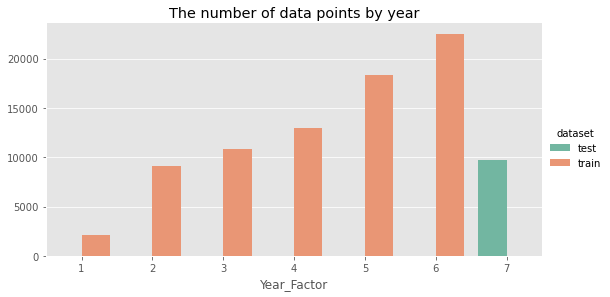

In [39]:
ax = sns.catplot(x='Year_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 kind='bar',
                 aspect=2,
                 height=4)\
.set(title="The number of data points by year",
     ylabel=None)

Text(0.5, 0, '')

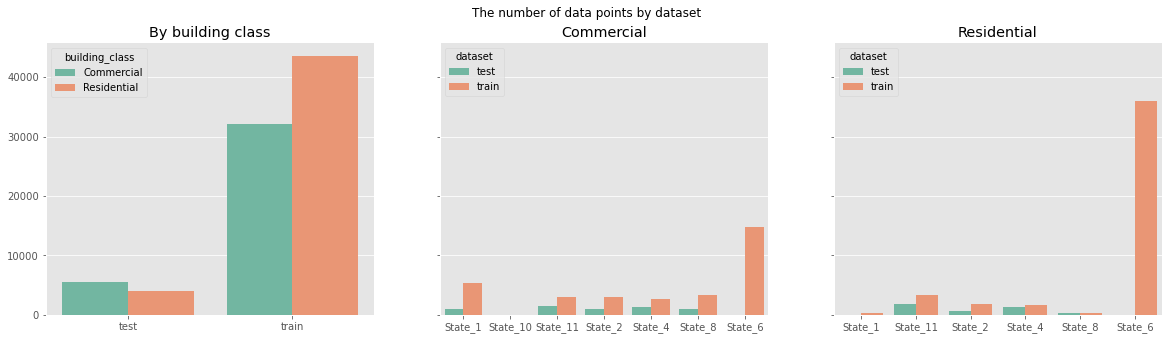

In [40]:
fig, ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
fig.suptitle("The number of data points by dataset")

sns.barplot(x='dataset',
            y='id',
            data=df_all.groupby(['dataset','building_class']).agg({'id':'count'}).reset_index(),
            hue='building_class',
            ax=ax[0],
            ci=False)

for e, s in enumerate(df_all['building_class'].unique(),1):
    sns.barplot(x='State_Factor',
                y='id',
                data=df_all[df_all['building_class']==s].groupby(['dataset','State_Factor']).agg({'id':'count'}).reset_index(),
                hue='dataset',
                ax=ax[e],
                ci=False)
    ax[e].set_title(s)
    ax[e].set_ylabel("")
    ax[e].set_xlabel("")

ax[0].set_title("By building class")
ax[0].set_ylabel("")
ax[0].set_xlabel("")

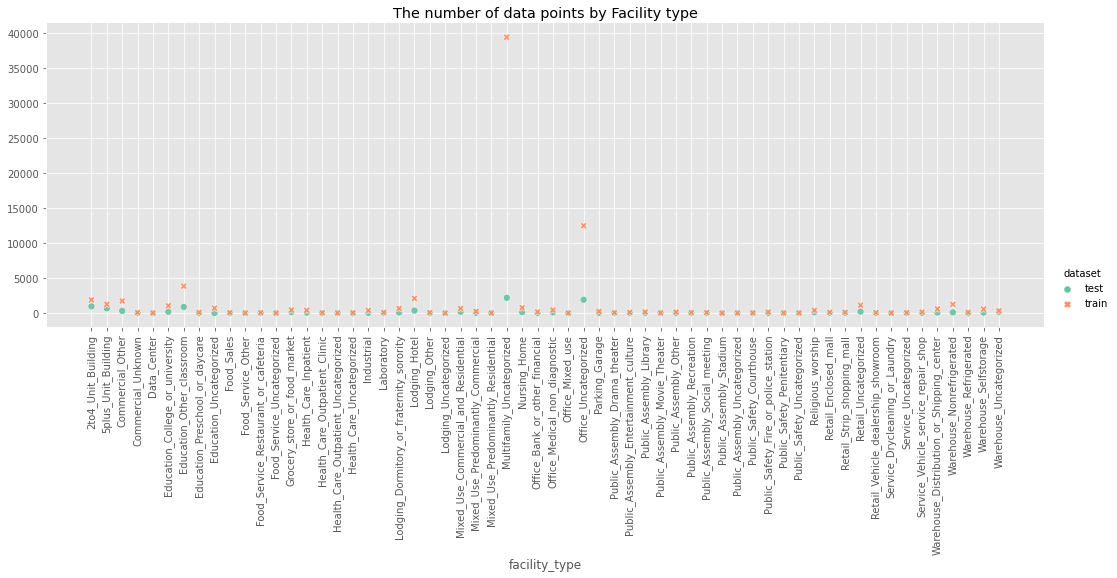

In [41]:
ax = sns.relplot(x='facility_type', 
                 y='id', 
                 data=df_all.groupby(['dataset','facility_type']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 style='dataset',
                 aspect=3,
                 height=5,
                 s=50,
                 alpha=0.9
                )\
.set(title = "The number of data points by Facility type",
    ylabel=None)

ax.set_xticklabels(rotation=90) 
None

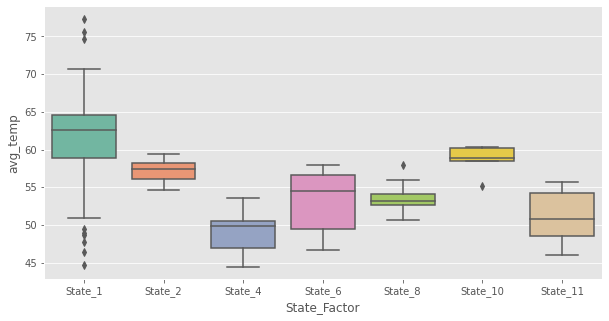

In [42]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=df_all[['avg_temp','State_Factor']].drop_duplicates(), y='avg_temp', x='State_Factor');

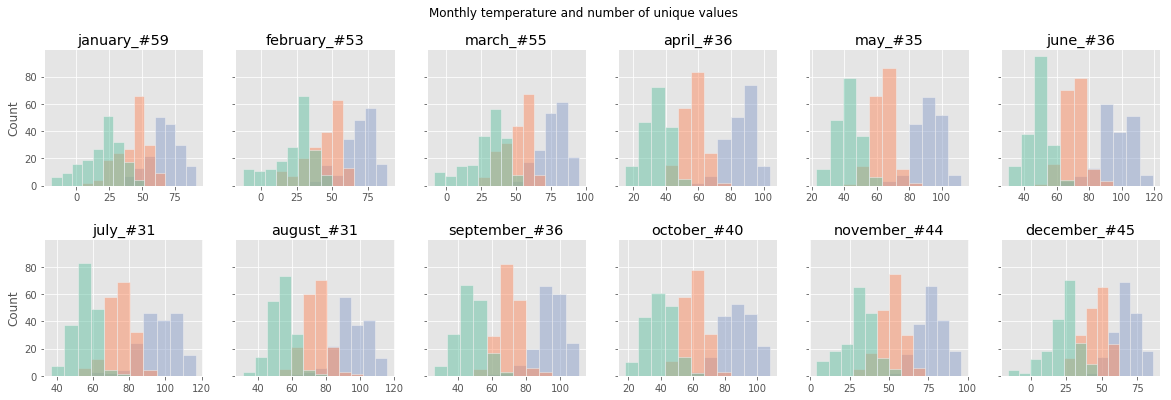

In [43]:
cols = [['january_min_temp', 'january_avg_temp', 'january_max_temp'],
        ['february_min_temp', 'february_avg_temp', 'february_max_temp'],
        ['march_min_temp', 'march_avg_temp', 'march_max_temp'], 
        ['april_min_temp','april_avg_temp', 'april_max_temp'], 
        ['may_min_temp', 'may_avg_temp','may_max_temp'], 
        ['june_min_temp', 'june_avg_temp', 'june_max_temp'],
        ['july_min_temp', 'july_avg_temp', 'july_max_temp'], 
        ['august_min_temp','august_avg_temp', 'august_max_temp'], 
        ['september_min_temp','september_avg_temp', 'september_max_temp'], 
        ['october_min_temp','october_avg_temp', 'october_max_temp'], 
        ['november_min_temp','november_avg_temp', 'november_max_temp'], 
        ['december_min_temp','december_avg_temp', 'december_max_temp']]
        
fig, ax = plt.subplots(2, 6, figsize=(20,6), sharey=True)
fig.suptitle("Monthly temperature and number of unique values")

for e, c in enumerate(cols):
    if e<=5:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[0,e], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
    else:
        sns.histplot(df_all[c].drop_duplicates(), ax=ax[1,e-6], legend=False)\
        .set(title=c[0][:c[0].find('_')]+ '_#'+str(len(df_all[c[0]].unique())))
        
plt.subplots_adjust(hspace=0.4)

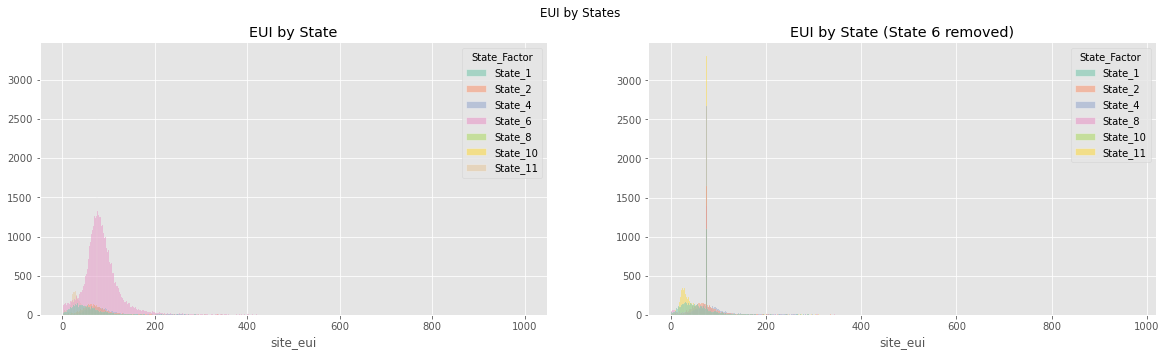

In [44]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("EUI by States")

sns.histplot(df_all, x='site_eui',hue='State_Factor', ax=ax[0])\
.set(title='EUI by State', ylabel=None)

sns.histplot(df_all[df_all['State_Factor']!='State_6'], x='site_eui',hue='State_Factor', ax=ax[1])\
.set(title='EUI by State (State 6 removed)', ylabel=None);

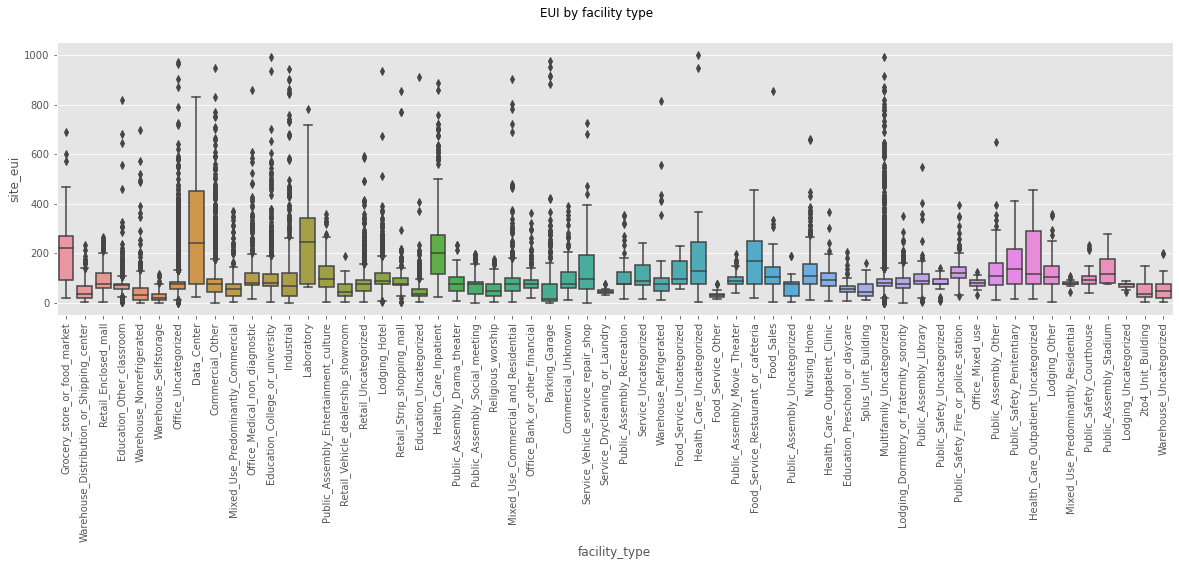

In [45]:
fig, ax = plt.subplots(figsize=(20,5))
fig.suptitle("EUI by facility type")
ax=sns.boxplot(data=df_all, y='site_eui', x='facility_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

# Data Preprocessing

In [46]:
groupby_cols = ['State_Factor','building_class','facility_type','floor_area','year_built']
df_all = df_all.sort_values(by=groupby_cols+['Year_Factor']).reset_index(drop=True)

In [47]:
df_all.loc[:,df_all.dtypes=='object'].columns

Index(['State_Factor', 'building_class', 'facility_type', 'dataset'], dtype='object')

In [48]:
target='site_eui'
cats = ['State_Factor', 'building_class', 'facility_type']
for col in cats:
    encoder = TargetEncoder()
    df_all[col] = encoder.fit_transform(df_all[col], df_all[target])

In [49]:
df_all

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset
0,3,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,45.7,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90,45,65.129032,91,52,70.016667,104,52,71.387097,102,54,71.322581,97,47,69.133333,98,43,61.000000,84,36,55.116667,77,24,45.387097,68,826,2542,4.50,0.0,0,60.056164,20,0,0,0,111,31,5,0,68.0,68.0,68.0,68.0,6.800000,1456,train
1,4,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,55,68.661290,95,46,59.650000,76,41,56.790323,68,497,1477,20.69,0.0,0,62.067123,0,0,0,0,27,6,0,0,68.0,68.0,68.0,68.0,8.200000,2673,train
2,5,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,49,69.580645,96,29,52.866667,75,28,48.580645,68,1319,1823,7.95,0.0,0,63.398630,4,0,0,0,136,52,10,0,68.0,68.0,68.0,68.0,12.300000,3769,train
3,7,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,48,64.193548,91,43,58.050000,69,38,51.887097,66,342,2112,25.24,0.0,0,59.894521,0,0,0,0,29,5,2,0,68.0,68.0,68.0,68.0,75.293716,76077,test
4,3,64.220446,84.203693,89.916951,10755.0,1937.0,68.0,9.1,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,35,56.967742,85,31,52.516667,76,16,43.338710,68,303,3108,4.16,0.0,0,57.082192,33,2,0,0,72,10,0,0,68.0,68.0,68.0,68.0,63.083288,2144,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7,84.223780,79.815538,83.425312,900000.0,1960.0,90.0,130.8,2,33.435484,61,16,37.660714,73,8,35.935484,69,28,54.800000,85,38,59.096774,92,40,68.689655,91,53,74.677419,91,52,70.564516,89,40,66.250000,91,33,58.129032,83,17,41.583333,74,3,29.933333,57,866,5264,43.54,27.3,51,52.646006,97,45,13,0,77,5,0,0,68.0,68.0,68.0,68.0,75.293716,79514,test
85458,6,84.223780,79.815538,83.425312,1179072.0,1959.0,96.0,3.0,8,29.827586,62,4,33.896552,62,24,45.967742,79,18,49.931034,81,37,59.161290,89,45,70.465517,90,57,77.083333,96,54,75.725806,95,40,68.200000,96,24,55.258065,85,20,44.316667,71,12,35.129032,58,1114,5074,35.78,13.9,18,53.839335,97,29,6,0,101,21,0,0,1.0,1.0,1.0,116.0,43.533097,68730,train
85459,7,84.223780,79.815538,83.425312,1179072.0,1959.0,92.0,130.8,2,33.435484,61,16,37.660714,73,8,35.935484,69,28,54.800000,85,38,59.096774,92,40,68.689655,91,53,74.677419,91,52,70.564516,89,40,66.250000,91,33,58.129032,83,17,41.583333,74,3,29.933333,57,866,5264,43.54,27.3,51,52.646006,97,45,13,0,77,5,0,0,68.0,68.

# Feature Engineering

In [50]:
# extract new weather statistics from the building location weather features
temp = [col for col in df_all.columns if 'temp' in col]

df_all['min_temp'] = df_all[temp].min(axis=1)
df_all['max_temp'] = df_all[temp].max(axis=1)
df_all['avg_temp'] = df_all[temp].mean(axis=1)
df_all['std_temp'] = df_all[temp].std(axis=1)
df_all['skew_temp'] = df_all[temp].skew(axis=1)

# by seasons
temp = pd.Series([col for col in df_all.columns if 'temp' in col])

winter_temp = temp[temp.apply(lambda x: ('january' in x or 'february' in x or 'december' in x))].values
spring_temp = temp[temp.apply(lambda x: ('march' in x or 'april' in x or 'may' in x))].values
summer_temp = temp[temp.apply(lambda x: ('june' in x or 'july' in x or 'august' in x))].values
autumn_temp = temp[temp.apply(lambda x: ('september' in x or 'october' in x or 'november' in x))].values


### winter
df_all['min_winter_temp'] = df_all[winter_temp].min(axis=1)
df_all['max_winter_temp'] = df_all[winter_temp].max(axis=1)
df_all['avg_winter_temp'] = df_all[winter_temp].mean(axis=1)
df_all['std_winter_temp'] = df_all[winter_temp].std(axis=1)
df_all['skew_winter_temp'] = df_all[winter_temp].skew(axis=1)
### spring
df_all['min_spring_temp'] = df_all[spring_temp].min(axis=1)
df_all['max_spring_temp'] = df_all[spring_temp].max(axis=1)
df_all['avg_spring_temp'] = df_all[spring_temp].mean(axis=1)
df_all['std_spring_temp'] = df_all[spring_temp].std(axis=1)
df_all['skew_spring_temp'] = df_all[spring_temp].skew(axis=1)
### summer
df_all['min_summer_temp'] = df_all[summer_temp].min(axis=1)
df_all['max_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['avg_summer_temp'] = df_all[summer_temp].mean(axis=1)
df_all['std_summer_temp'] = df_all[summer_temp].max(axis=1)
df_all['skew_summer_temp'] = df_all[summer_temp].max(axis=1)
## autumn
df_all['min_autumn_temp'] = df_all[autumn_temp].min(axis=1)
df_all['max_autumn_temp'] = df_all[autumn_temp].max(axis=1)
df_all['avg_autumn_temp'] = df_all[autumn_temp].mean(axis=1)
df_all['std_autumn_temp'] = df_all[autumn_temp].std(axis=1)
df_all['skew_autumn_temp'] = df_all[autumn_temp].skew(axis=1)

In [51]:
df_all['month_cooling_degree_days'] = df_all['cooling_degree_days']/12
df_all['month_heating_degree_days'] = df_all['heating_degree_days']/12

In [52]:
# total area
df_all['building_area'] = df_all['floor_area'] * df_all['ELEVATION']
# rating energy by floor
df_all['floor_energy_star_rating'] = df_all['energy_star_rating']/df_all['ELEVATION']

# Checking target variable transformation

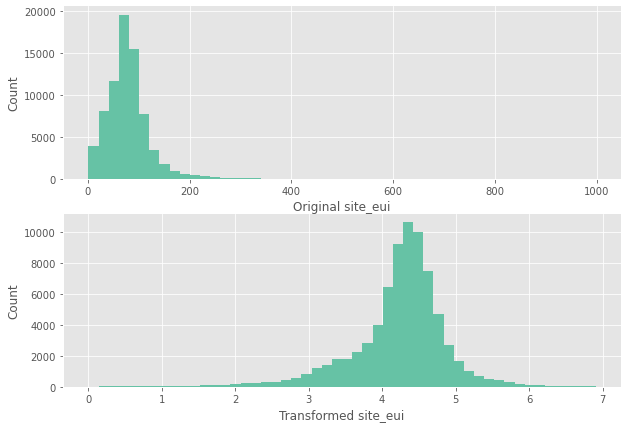

In [53]:
target = 'site_eui'
plt.figure(figsize=(10,7))
# plot the original variable vs sale price    
plt.subplot(2, 1, 1)
train[target].hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Original ' + target)

# plot transformed variable vs sale price
plt.subplot(2, 1, 2)
np.log(train[target]).hist(bins=50)
plt.ylabel('Count')
plt.xlabel('Transformed ' + target);

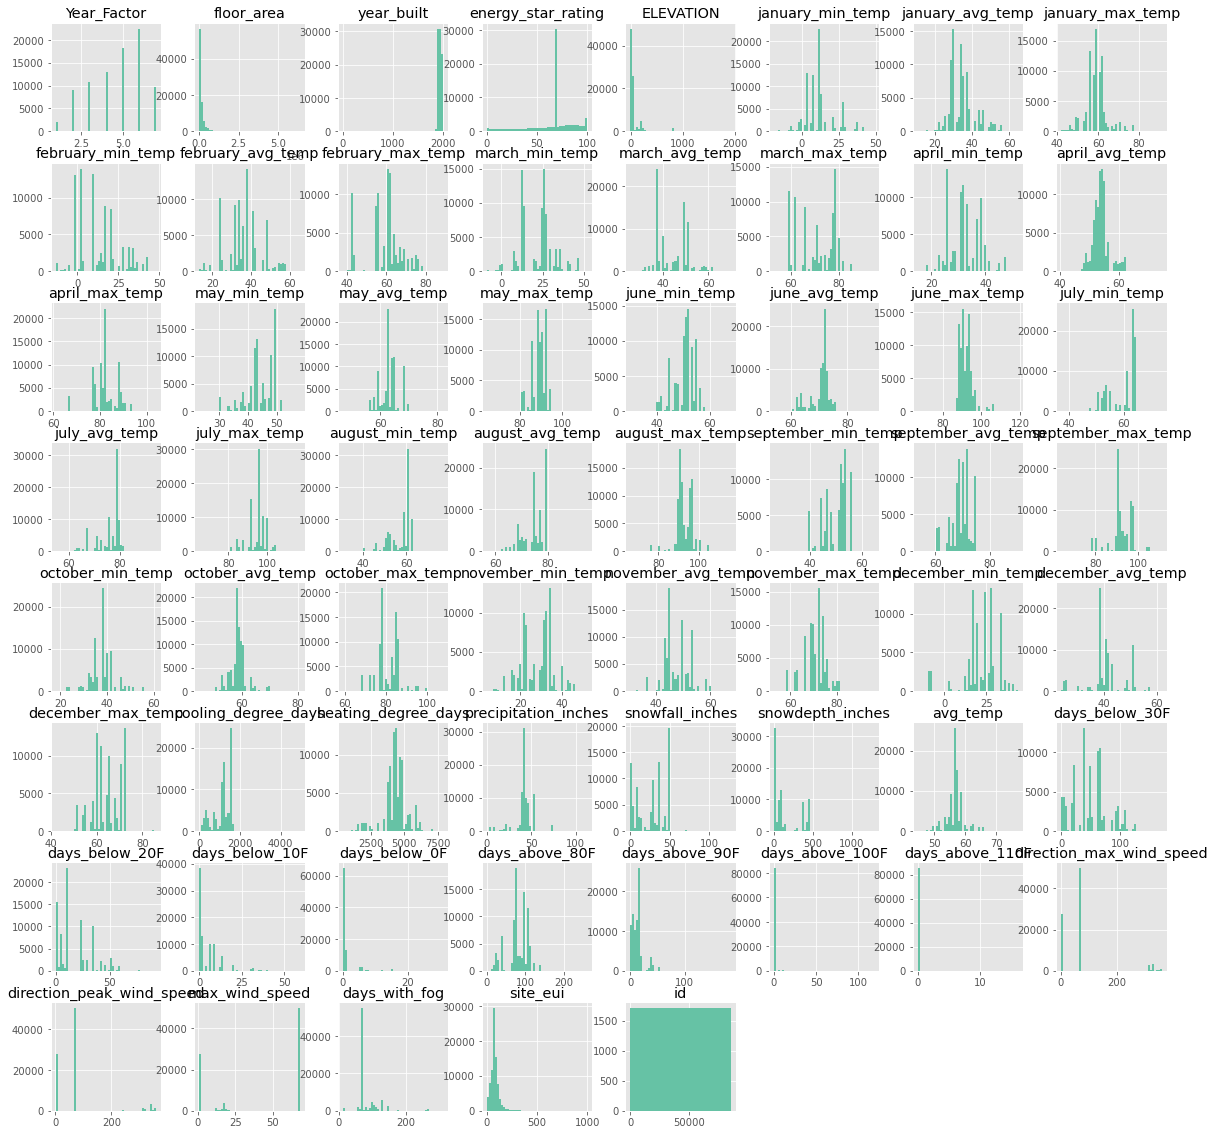

In [54]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].hist(bins=50, figsize=(20,20))
plt.show();

In [55]:
nums = train.loc[:, train.dtypes != 'object'].columns
df_all[nums].skew().sort_values(key=abs, ascending=False)[:5]

days_above_110F    89.873857
days_above_100F    24.615438
year_built        -11.842043
floor_area          6.701786
ELEVATION           5.140444
dtype: float64

In [56]:
skewed = ['days_above_110F', 'days_above_100F']

for var in skewed:
    
    # map the variable values into 0 and 1
    df_all[var] = np.where(df_all[var]==0, 0, 1)

In [57]:
df_all.shape

(85462, 93)

In [58]:
df_all.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,45.7,26,44.516129,64,30,49.392857,69,37,55.967742,77,40,61.783333,90,45,65.129032,91,52,70.016667,104,52,71.387097,102,54,71.322581,97,47,69.133333,98,...,68.0,68.0,68.0,68.0,6.800000,1456,train,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,1.487965
1,4,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,120.4,41,55.096774,73,42,54.875000,71,47,59.032258,76,47,60.100000,90,51,63.483871,92,52,64.250000,87,53,66.903226,90,57,67.016129,80,56,68.383333,83,...,68.0,68.0,68.0,68.0,8.200000,2673,train,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.564784
2,5,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,29,51.387097,77,36,56.803571,75,40,61.435484,85,41,60.966667,91,45,62.887097,90,55,72.983333,106,60,74.516129,103,58,74.774194,104,53,73.583333,105,...,68.0,68.0,68.0,68.0,12.300000,3769,train,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,1.150592
3,7,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,38,50.596774,64,40,54.482143,66,42,56.935484,77,45,58.450000,78,49,60.903226,87,51,63.150000,97,53,64.258065,85,53,65.854839,88,54,69.766667,104,...,68.0,68.0,68.0,68.0,75.293716,76077,test,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.150592
4,3,64.220446,84.203693,89.916951,10755.0,1937.0,68.0,9.1,22,44.790323,65,25,47.892857,71,32,53.112903,79,34,58.866667,87,35,62.096774,91,44,66.283333,99,48,65.693548,91,45,67.080645,92,42,65.950000,96,...,68.0,68.0,68.0,68.0,63.083288,2144,train,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,7.472527


In [59]:
cats = ['State_Factor', 'facility_type', 'building_class']

# typecasting numerical features
for col in df_all.drop(columns=cats + ['dataset', 'id', 'site_eui']).columns:
    df_all[col] = df_all[col].astype('float64')

In [60]:
df_all.drop(columns=cats)

,Year_Factor,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,...,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,10149.0,1931.0,68.0,45.7,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,43.0,61.000000,84.0,...,68.0,68.0,68.0,68.0,6.800000,1456,train,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,1.487965
1,4.0,10149.0,1931.0,68.0,120.4,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,55.0,68.661290,95.0,...,68.0,68.0,68.0,68.0,8.200000,2673,train,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.564784
2,5.0,10149.0,1931.0,68.0,59.1,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,49.0,69.580645,96.0,...,68.0,68.0,68.0,68.0,12.300000,3769,train,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,1.150592
3,7.0,10149.0,1931.0,68.0,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.450000,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,48.0,64.193548,91.0,...,68.0,68.0,68.0,68.0,75.293716,76077,test,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.150592
4,3.0,10755.0,1937.0,68.0,9.1,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,35.0,56.967742,85.0,...,68.0,68.0,68.0,68.0,63.083288,2144,train,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,7.472527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7.0,900000.0,1960.0,90.0,130.8,2.0,33.435484,61.0,16.0,37.660714,73.0,8.0,35.935484,69.0,28.0,54.800000,85.0,38.0,59.096774,92.0,40.0,68.6

In [61]:
train = df_all[df_all['dataset']=='train']
test = df_all[df_all['dataset']=='test']

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

test_ids = test['id']
train_ids = train['id']

target = train['site_eui']

train = train.drop(['id', 'dataset', 'site_eui'], axis=1)
test = test.drop(['id', 'dataset', 'site_eui'], axis=1)

In [62]:
train

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,3.0,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,45.7,26.0,44.516129,64.0,30.0,49.392857,69.0,37.0,55.967742,77.0,40.0,61.783333,90.0,45.0,65.129032,91.0,52.0,70.016667,104.0,52.0,71.387097,102.0,54.0,71.322581,97.0,47.0,69.133333,98.0,...,31.0,1.0,0.0,68.0,68.0,68.0,68.0,24.0,104.0,21.308416,0.281828,24.0,69.0,46.699565,17.630529,0.021018,37.0,91.0,62.542234,20.284168,0.250054,52.0,104.0,74.858483,104.0,104.0,36.0,98.0,63.361111,20.462133,0.360253,68.833333,211.833333,463809.3,1.487965
1,4.0,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,120.4,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,...,6.0,0.0,0.0,68.0,68.0,68.0,68.0,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,1221939.6,0.564784
2,5.0,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,29.0,51.387097,77.0,36.0,56.803571,75.0,40.0,61.435484,85.0,41.0,60.966667,91.0,45.0,62.887097,90.0,55.0,72.983333,106.0,60.0,74.516129,103.0,58.0,74.774194,104.0,53.0,73.583333,105.0,...,52.0,1.0,0.0,68.0,68.0,68.0,68.0,28.0,106.0,21.906277,0.212369,28.0,77.0,52.196813,18.727631,0.005259,40.0,91.0,64.143250,20.398627,0.230872,55.0,106.0,78.697073,106.0,106.0,29.0,105.0,67.003405,23.881873,0.162329,109.916667,151.916667,599805.9,1.150592
3,3.0,64.220446,84.203693,89.916951,10755.0,1937.0,68.0,9.1,22.0,44.790323,65.0,25.0,47.892857,71.0,32.0,53.112903,79.0,34.0,58.866667,87.0,35.0,62.096774,91.0,44.0,66.283333,99.0,48.0,65.693548,91.0,45.0,67.080645,92.0,42.0,65.950000,96.0,...,10.0,0.0,0.0,68.0,68.0,68.0,68.0,16.0,99.0,22.272150,0.113857,16.0,71.0,44.780210,20.572244,-0.084189,32.0,91.0,59.119594,22.864101,0.160184,44.0,99.0,68.673059,99.0,99.0,31.0,96.0,60.048268,22.548770,0.276234,25.250000,259.000000,97870.5,7.472527
4,4.0,64.220446,84.203693,89.916951,10755.0,1937.0,68.0,9.1,41.0,55.096774,73.0,42.0,54.875000,71.0,47.0,59.032258,76.0,47.0,60.100000,90.0,51.0,63.483871,92.0,52.0,64.250000,87.0,53.0,66.903226,90.0,57.0,67.016129,80.0,56.0,68.383333,83.0,...,6.0,0.0,0.0,68.0,68.0,68.0,68.0,41.0,95.0,14.980311,0.428700,41.0,73.0,55.862455,12.779553,0.081583,47.0,92.0,65.068459,17.251378,0.670141,52.0,90.0,68.574373,90.0,90.0,46.0,95.0,67.521625,15.342943,0.494753,41.416667,123.083333,97870.5,7.472527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75752,6.0,84.223780,79.815538,83.425312,794056.0,1962.0,88.0,18.3,10.0,29.709677,61.0,4.0,34.051724,62.0,22.0,46.467742,80

In [63]:
test

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
0,7.0,64.220446,84.203693,89.916951,10149.0,1931.0,68.0,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,...,5.0,1.0,0.0,68.0,68.0,68.0,68.0,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,599805.9,1.150592
1,7.0,64.220446,84.203693,89.916951,10755.0,1937.0,68.0,18.6,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,...,5.0,1.0,0.0,68.0,68.0,68.0,68.0,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,200043.0,3.655914
2,7.0,64.220446,84.203693,89.916951,11730.0,1937.0,68.0,2.4,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,...,5.0,1.0,0.0,68.0,68.0,68.0,68.0,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,28152.0,28.333333
3,7.0,64.220446,84.203693,89.916951,13000.0,1946.0,68.0,59.1,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,...,5.0,1.0,0.0,68.0,68.0,68.0,68.0,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,768300.0,1.150592
4,7.0,64.220446,84.203693,89.916951,13200.0,1907.0,68.0,43.9,38.0,50.596774,64.0,40.0,54.482143,66.0,42.0,56.935484,77.0,45.0,58.45,78.0,49.0,60.903226,87.0,51.0,63.150000,97.0,53.0,64.258065,85.0,53.0,65.854839,88.0,54.0,69.766667,104.0,...,5.0,1.0,0.0,68.0,68.0,68.0,68.0,38.0,104.0,16.708230,0.725826,38.0,66.0,52.107335,11.619161,-0.034349,42.0,87.0,61.587634,15.818993,0.417654,51.0,97.0,68.918100,97.0,97.0,43.0,104.0,66.778913,19.843743,0.883927,28.500000,176.000000,579480.0,1.548975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,7.0,84.223780,79.815538,83.425312,852000.0,2009.0,59.0,130.8,2.0,33.435484,61.0,16.0,37.660714,73.0,8.0,35.935484,69.0,28.0,54.80,85.0,3

In [64]:
y_test = pd.read_csv('../Y_test.csv')

X_train = train
X_test = test
y_train = target
y_test = y_test['site_eui']
print('Train: ', X_train.shape)
print('Test:', X_test.shape)
print('Samples: ', y_train.shape)
print('Targets: ', y_test.shape)

Train:  (75757, 90)
Test: (9705, 90)
Samples:  (75757,)
Targets:  (9705,)


In [65]:
y_test

0       166.588554
1       259.381565
2       158.537090
3       261.441520
4       242.967711
           ...    
9700     23.677329
9701     20.512284
9702     39.285975
9703     29.529438
9704     15.492899
Name: site_eui, Length: 9705, dtype: float64

# Catboost Algorithm

In [66]:
catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)

In [67]:
catb.fit(X_train, y_train)
                 

y_pred = catb.predict(X_test)

0:	learn: 57.8460326	total: 701ms	remaining: 5m 49s
75:	learn: 44.6575093	total: 45.3s	remaining: 4m 12s
150:	learn: 41.7742222	total: 1m 31s	remaining: 3m 30s
225:	learn: 40.5208026	total: 2m 12s	remaining: 2m 40s
300:	learn: 39.8393406	total: 2m 50s	remaining: 1m 52s
375:	learn: 39.2973139	total: 3m 41s	remaining: 1m 13s
450:	learn: 38.8314450	total: 4m 33s	remaining: 29.7s
499:	learn: 38.5042063	total: 5m 7s	remaining: 0us


In [68]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 73.35961319939655
 MAE: 48.14661548907459
 MSE: 5381.632848765077
 R2: -0.48841616291159884


# XGBoost

In [69]:
xgb = XGBRegressor(n_estimators=500, reg_alpha=0.01, n_jobs=-1)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [70]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 81.7715255189862
 MAE: 53.73867686579592
 MSE: 6686.58238570221
 R2: -0.849330412758081


# Random Forest

In [71]:
rf = RandomForestRegressor(random_state=1, criterion='mse', max_depth = 15, min_samples_split= 2)
rf.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

In [72]:
print(" Training data scores\n","--"*10)
print(" RMSE:", np.sqrt(mean_squared_error(y_test,y_pred)))
print(" MAE:", mean_absolute_error(y_test,y_pred))
print(" MSE:", mean_squared_error(y_test,y_pred))
print(" R2:", r2_score(y_test,y_pred))

 Training data scores
 --------------------
 RMSE: 81.7715255189862
 MAE: 53.73867686579592
 MSE: 6686.58238570221
 R2: -0.849330412758081



# Model Evaluation

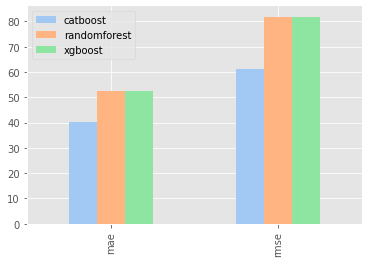

In [73]:
error_rec = {
    "catboost": {
        "mae": 40.29268484855883,
        "rmse": 61.19378120765249,
    },
    "randomforest": {
        "mae": 52.41012420250038,
        "rmse": 81.8514058171361,
    },
    "xgboost": {
        "mae": 52.41012420250038,
        "rmse": 81.8514058171361,
    },
}
pd.DataFrame(error_rec).plot(kind="bar", 
             color=[
                 sns.color_palette("pastel")[0], 
                 sns.color_palette("pastel")[1], 
                 sns.color_palette("pastel")[2], 
                 sns.color_palette("pastel")[3]]);

# Save Model for Deployement

In [74]:
cb_model =  CatBoostRegressor()

In [75]:
cb_model.fit(X_train, y_train)

Learning rate set to 0.08112
0:	learn: 56.7197126	total: 49.6ms	remaining: 49.5s
1:	learn: 55.4208807	total: 84.4ms	remaining: 42.1s
2:	learn: 54.2480075	total: 127ms	remaining: 42.3s
3:	learn: 53.2477462	total: 266ms	remaining: 1m 6s
4:	learn: 52.3568235	total: 338ms	remaining: 1m 7s
5:	learn: 51.5627595	total: 385ms	remaining: 1m 3s
6:	learn: 50.8513624	total: 433ms	remaining: 1m 1s
7:	learn: 50.2314396	total: 478ms	remaining: 59.3s
8:	learn: 49.6873703	total: 524ms	remaining: 57.7s
9:	learn: 49.2007379	total: 566ms	remaining: 56s
10:	learn: 48.7377466	total: 616ms	remaining: 55.4s
11:	learn: 48.3722658	total: 653ms	remaining: 53.8s
12:	learn: 48.0365676	total: 692ms	remaining: 52.5s
13:	learn: 47.7073463	total: 729ms	remaining: 51.4s
14:	learn: 47.4310832	total: 763ms	remaining: 50.1s
15:	learn: 47.1565223	total: 804ms	remaining: 49.5s
16:	learn: 46.9239537	total: 849ms	remaining: 49.1s
17:	learn: 46.7364953	total: 884ms	remaining: 48.2s
18:	learn: 46.5111275	total: 919ms	remaining:

In [76]:
y_pred =cb_model.predict(X_test)

In [77]:
y_pred

array([ 93.48574373, 102.16419865,  58.06337509, ...,  54.29904479,
        55.21866149,  67.03852691])

# Hyperparameter Tuning
#### Using CrossValidation on CatBoost

In [78]:
# prepaere the out of folds predictions 
train_oof = np.zeros((train.shape[0],))
test_preds = np.zeros(test.shape[0])

NUM_FOLDS = 5
kf = KFold(n_splits=5, shuffle=True, random_state=0)


for fold, (train_idx, test_idx) in tqdm.tqdm(enumerate(kf.split(train, target))):
    X_train, X_test = train.iloc[train_idx][test.columns], train.iloc[test_idx][test.columns]
    y_train, y_test = target[train_idx], target[test_idx]
    
    catb = CatBoostRegressor(iterations=500,
                         learning_rate=0.02,
                         depth=12,
                         eval_metric='RMSE',
#                         early_stopping_rounds=42,
                         random_seed = 23,
                         bagging_temperature = 0.2,
                         od_type='Iter',
                         metric_period = 75,
                         od_wait=100)
    # train model
    catb.fit(X_train, y_train)
                 

    y_pred = catb.predict(X_test)

   

0it [00:00, ?it/s]

0:	learn: 58.0451568	total: 592ms	remaining: 4m 55s
75:	learn: 45.0139868	total: 45.9s	remaining: 4m 15s
150:	learn: 42.0521460	total: 1m 29s	remaining: 3m 27s
225:	learn: 40.6271839	total: 2m 13s	remaining: 2m 41s
300:	learn: 39.8233109	total: 3m 35s	remaining: 2m 22s
375:	learn: 39.1676339	total: 4m 12s	remaining: 1m 23s
450:	learn: 38.6185209	total: 4m 48s	remaining: 31.3s
499:	learn: 38.2420181	total: 5m 12s	remaining: 0us


1it [05:14, 314.08s/it]

0:	learn: 57.9703244	total: 591ms	remaining: 4m 54s
75:	learn: 44.9998457	total: 37.2s	remaining: 3m 27s
150:	learn: 42.0384290	total: 1m 13s	remaining: 2m 50s
225:	learn: 40.7210727	total: 1m 50s	remaining: 2m 13s
300:	learn: 40.0348919	total: 2m 27s	remaining: 1m 37s
375:	learn: 39.4420006	total: 3m 13s	remaining: 1m 4s
450:	learn: 38.8471782	total: 3m 54s	remaining: 25.6s
499:	learn: 38.4744127	total: 4m 20s	remaining: 0us


2it [17:34, 564.65s/it]

0:	learn: 57.6666363	total: 577ms	remaining: 4m 47s
75:	learn: 44.2485920	total: 44.9s	remaining: 4m 10s
150:	learn: 41.2438848	total: 1m 30s	remaining: 3m 29s
225:	learn: 39.9049481	total: 2m 18s	remaining: 2m 47s
300:	learn: 39.0271428	total: 3m 5s	remaining: 2m 2s
375:	learn: 38.3602775	total: 3m 52s	remaining: 1m 16s
450:	learn: 37.7805211	total: 4m 41s	remaining: 30.6s
499:	learn: 37.4084751	total: 5m 13s	remaining: 0us


3it [22:49, 450.86s/it]

0:	learn: 58.4712304	total: 769ms	remaining: 6m 23s
75:	learn: 45.0181962	total: 52.9s	remaining: 4m 55s
150:	learn: 41.9738167	total: 1m 52s	remaining: 4m 21s
225:	learn: 40.5798434	total: 2m 25s	remaining: 2m 57s
300:	learn: 39.7620643	total: 2m 58s	remaining: 1m 58s
375:	learn: 39.1682220	total: 3m 29s	remaining: 1m 9s
450:	learn: 38.6048523	total: 4m 3s	remaining: 26.5s
499:	learn: 38.2459761	total: 4m 23s	remaining: 0us


4it [33:24, 523.59s/it]

0:	learn: 57.0972604	total: 439ms	remaining: 3m 38s
75:	learn: 44.1585668	total: 34.5s	remaining: 3m 12s
150:	learn: 41.3305373	total: 1m 7s	remaining: 2m 35s
225:	learn: 40.1072775	total: 1m 39s	remaining: 2m 1s
300:	learn: 39.3852768	total: 2m 12s	remaining: 1m 27s
375:	learn: 38.7873363	total: 2m 44s	remaining: 54.4s
450:	learn: 38.2845183	total: 3m 16s	remaining: 21.3s
499:	learn: 37.9134886	total: 3m 37s	remaining: 0us


5it [37:02, 444.55s/it]


In [79]:
oof = cb_model.predict(X_test)
train_oof[test_idx] = oof
test_preds += cb_model.predict(test)/NUM_FOLDS      
print(f"out-of-folds prdiction ==== fold_{fold} RMSE",np.sqrt(mean_squared_error(oof, y_test, squared=False)))



out-of-folds prdiction ==== fold_4 RMSE 6.10572404275869


# Final Evaluation (CatBoost)

Text(0.5, 0, 'iteration')

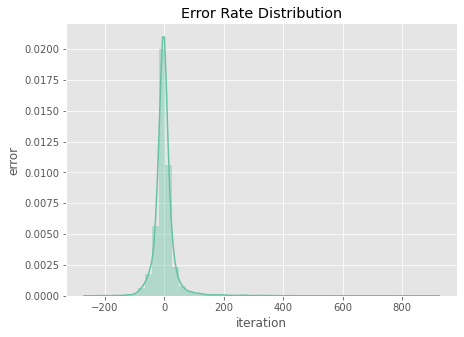

In [80]:
y_hat_tuned = catb.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

# #### Using CrossValidation on RandomForest

In [81]:
# cross validating training data
kfolds = KFold(n_splits=3, shuffle=True, random_state=42)

# Objective function
def random_forest_objective(trial, data=X_train, target=y_train):
    # Dictionary to store best parameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_features": trial.suggest_float("max_features", 0.01, 0.95)
    }
     
    model = RandomForestRegressor(**param)
    
    # Setting random seed and kfolds for cross-validation
    kfolds = KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = cross_val_score(model, data, target, cv=kfolds, scoring="neg_root_mean_squared_error")
    return scores.mean()

In [82]:
def tuner(objective, n=5, direction='minimize'): 
    # Create Study object
    study = optuna.create_study(direction="minimize")

    # Optimize the study
    study.optimize(objective, n_trials=n)

    # Print the result
    best_params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score}")
    print(f"Optimized parameters: {best_params}\n")
    print("<<<<<<<<<< Tuning complete... >>>>>>>>>>")
    
    # Return best parameters for the model
    return best_params, best_score

In [83]:
%%time
rf_param, rf_score = tuner(random_forest_objective,1)
rf_tuned_model = RandomForestRegressor(**rf_param)

[I 2022-03-22 15:44:11,445] A new study created in memory with name: no-name-1f2c57a4-c072-4715-8a98-aff0adb471f4
[I 2022-03-22 15:56:45,657] Trial 0 finished with value: -43.05685664937105 and parameters: {'n_estimators': 439, 'max_depth': 10, 'min_samples_split': 10, 'max_features': 0.4458833010009982}. Best is trial 0 with value: -43.05685664937105.


Best score: -43.05685664937105
Optimized parameters: {'n_estimators': 439, 'max_depth': 10, 'min_samples_split': 10, 'max_features': 0.4458833010009982}

<<<<<<<<<< Tuning complete... >>>>>>>>>>
Wall time: 12min 34s


In [84]:
rf_tuned_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=0.4458833010009982,
                      min_samples_split=10, n_estimators=439)

# Final Evaluation (CatBoost)

Text(0.5, 0, 'iteration')

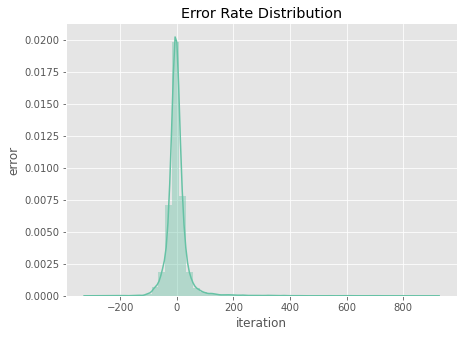

In [85]:
y_hat_tuned = rf_tuned_model.predict(X_test)

plt.figure(figsize = (7,5))
sns.distplot(y_test - y_hat_tuned)
plt.title("Error Rate Distribution");
plt.ylabel("error")
plt.xlabel("iteration")

# Saving Models

In [92]:
import pickle 
pickle_out = open("cb_model.pkl", mode = "wb") 
pickle.dump(cb_model, pickle_out) 
pickle_out.close()

# Explainable AI

In [88]:
shap.initjs()

In [89]:
X_sample = X_train.sample(2000)
X_sample

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,...,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,min_temp,max_temp,std_temp,skew_temp,min_winter_temp,max_winter_temp,avg_winter_temp,std_winter_temp,skew_winter_temp,min_spring_temp,max_spring_temp,avg_spring_temp,std_spring_temp,skew_spring_temp,min_summer_temp,max_summer_temp,avg_summer_temp,std_summer_temp,skew_summer_temp,min_autumn_temp,max_autumn_temp,avg_autumn_temp,std_autumn_temp,skew_autumn_temp,month_cooling_degree_days,month_heating_degree_days,building_area,floor_energy_star_rating
26628,1.0,87.481012,84.203693,122.149157,153067.0,1931.0,4.0,3.4,6.0,29.677419,53.0,15.0,36.035714,67.0,20.0,42.322581,77.0,35.0,54.300000,83.0,46.0,64.483871,89.0,56.0,72.316667,95.0,63.0,80.241935,104.0,59.0,75.274194,94.0,51.0,70.033333,86.0,...,16.0,1.0,0.0,1.0,1.0,1.0,12.0,6.0,104.0,23.915597,-0.180370,6.0,67.0,37.113287,21.051146,0.026865,20.0,89.0,56.789606,23.324683,-0.054501,56.0,104.0,77.648088,104.0,104.0,33.0,86.0,59.890382,19.081629,-0.009883,110.916667,361.250000,520427.8,1.176471
48213,6.0,87.481012,79.815538,83.425312,71795.0,1964.0,48.0,3.4,11.0,34.451613,59.0,-1.0,37.706897,61.0,26.0,48.870968,79.0,26.0,53.333333,82.0,43.0,62.790323,92.0,52.0,72.250000,88.0,63.0,78.677419,96.0,61.0,79.177419,96.0,54.0,71.800000,91.0,...,17.0,0.0,0.0,1.0,1.0,1.0,68.0,-1.0,96.0,24.441409,-0.376681,-1.0,61.0,35.277469,22.613829,-0.314577,26.0,92.0,56.999403,23.887898,0.075903,52.0,96.0,76.233871,96.0,96.0,34.0,91.0,61.591637,19.839052,0.086495,124.083333,354.333333,244103.0,14.117647
9813,5.0,61.181698,79.815538,46.546600,36660.0,1907.0,99.0,18.3,28.0,45.419355,63.0,32.0,48.321429,62.0,29.0,50.725806,71.0,37.0,51.850000,78.0,41.0,59.080645,81.0,48.0,67.083333,90.0,55.0,70.919355,96.0,51.0,68.403226,89.0,44.0,60.433333,80.0,...,2.0,0.0,0.0,68.0,68.0,68.0,68.0,27.0,96.0,18.091423,0.288022,28.0,63.0,45.464030,13.728244,-0.020554,29.0,81.0,55.406272,18.372389,0.112829,48.0,96.0,70.600657,96.0,96.0,27.0,80.0,54.711111,16.332372,-0.022392,35.833333,311.833333,670878.0,5.409836
47737,3.0,87.481012,79.815538,83.425312,70695.0,1940.0,68.0,42.7,11.0,35.080645,61.0,17.0,33.910714,55.0,27.0,40.145161,59.0,33.0,52.983333,82.0,42.0,62.790323,90.0,53.0,72.650000,92.0,64.0,79.838710,98.0,59.0,74.596774,90.0,47.0,67.866667,96.0,...,11.0,0.0,0.0,310.0,320.0,13.4,63.0,11.0,98.0,23.549611,-0.056041,11.0,71.0,37.948861,20.807217,0.314929,27.0,90.0,54.324313,21.471823,0.527483,53.0,98.0,75.898387,98.0,98.0,23.0,96.0,59.478913,23.149084,0.108344,106.000000,389.166667,3018676.5,1.592506
57711,3.0,87.481012,79.815538,83.425312,103852.0,1948.0,68.0,15.2,11.0,35.080645,61.0,17.0,33.910714,55.0,27.0,40.145161,59.0,33.0,52.983333,82.0,42.0,62.790323,90.0,53.0,72.650000,92.0,64.0,79.838710,98.0,59.0,74.596774,90.0,47.0,67.866667,96.0,...,11.0,0.0,0.0,68.0,68.0,68.0,68.0,11.0,98.0,23.549611,-0.056041,11.0,71.0,37.948861,20.807217,0.314929,27.0,90.0,54.324313,21.471823,0.527483,53.0,98.0,75.898387,98.0,98.0,23.0,96.0,59.478913,23.149084,0.108344,106.000000,389.166667,1578550.4,4.473684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37723,6.0,87.481012,79.815538,83.425312,52428.0,1958.0,68.0,25.0,11.0,34.451613,59.0,-1.0,37.706897,61.

In [93]:
shap_values = shap.TreeExplainer(catb).shap_values(X_sample)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

KeyboardInterrupt: 

In [91]:
shap.summary_plot(shap_values, X_sample, plot_type="bar")

NameError: name 'shap_values' is not defined

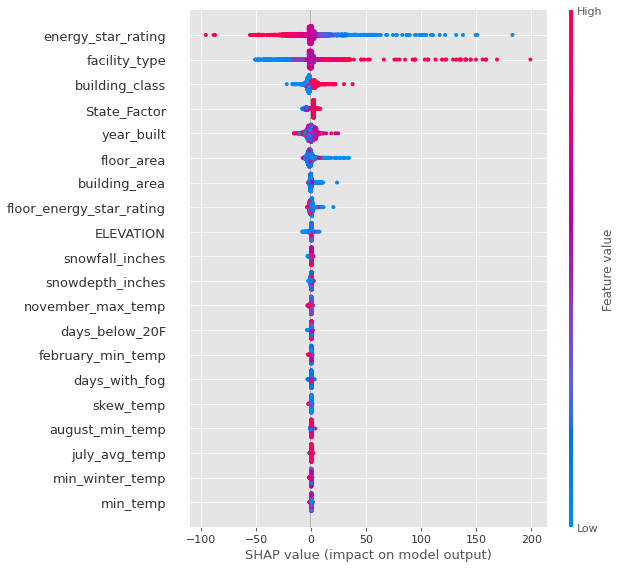

In [ ]:
shap.summary_plot(shap_values, X_sample)

In [ ]:
limit = 200
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[0:limit,:], X_sample.iloc[0:limit,:])

In [ ]:
row = 60
print(y_pred[row])
shap.initjs()
shap.force_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], shap_values[row], X_sample.iloc[row])

73.51277350469675


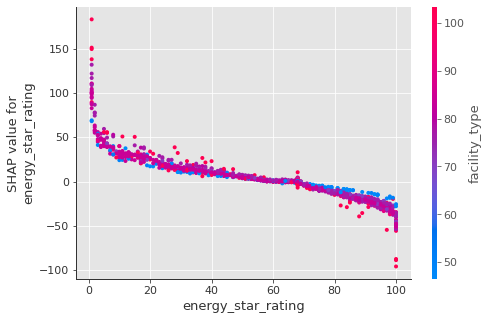

In [ ]:
shap.dependence_plot('energy_star_rating', shap_values, X_sample)

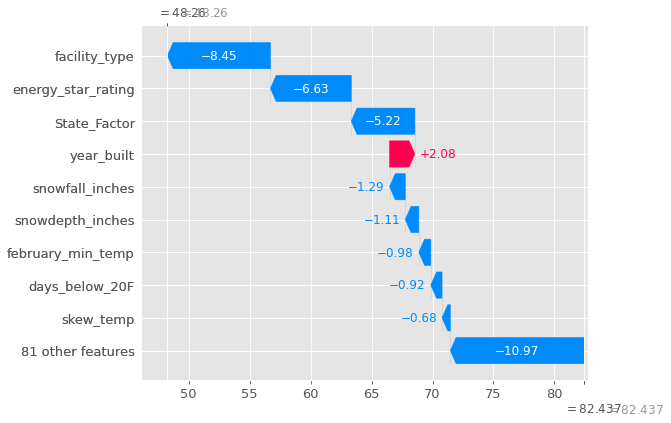

In [ ]:
row = 111
shap.plots._waterfall.waterfall_legacy(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                                       shap_values[row],
                                       feature_names=X_sample.columns.tolist()
                                      )

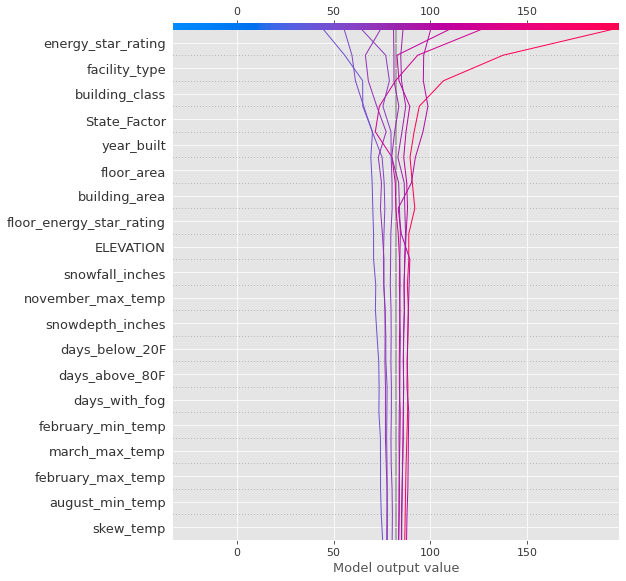

In [ ]:
start = 120
limit = 130

shap.decision_plot(shap.TreeExplainer(rf_tuned_model).expected_value[0], 
                   shap_values[start:limit], 
                   feature_names=X_sample.columns.tolist())

In [2]:
from PIL import Image
img = Image.open('C:\\Users\\Suwarna\\Downloads\\energy.png')